# 3W Dataset Processing & Scaling Methods

Data preprocessing for the 3W dataset - fault detection in oil wells.

## Processing Steps
- Data loading with optional sampling
- Multiple scaling methods comparison  
- Cross-validation with real/simulated separation
- Time windowing for sequence models
- Data persistence for training notebooks

## Configuration
All parameters managed in `src/config.py`

In [1]:
# Import and Validate Configuration
import os
from src import DataLoader, DataPreprocessor, DataVisualizer, CrossValidator
from src import config

# Validate configuration
config_warnings = config.validate_config()
if config_warnings:
    print("⚠️ Configuration Warnings:")
    for warning in config_warnings:
        print(f"   • {warning}")
    print()

print("🚀 3W Dataset Processing Methods Loaded")
print(
    f"📋 Configuration: Target features: {len(config.TARGET_FEATURES)}, "
    f"Scaling: {config.DEFAULT_SCALING_METHOD}, "
    f"CV folds: {config.N_FOLDS}, "
    f"Window: {config.WINDOW_SIZE}"
)
if config.ENABLE_DATA_SAMPLING:
    print(f"📊 Data sampling: 1/{config.SAMPLING_RATE} ({config.SAMPLING_METHOD})")
print(f"🎲 Random seed: {config.RANDOM_SEED}")

🚀 3W Dataset Processing Methods Loaded
📋 Configuration: Target features: 4, Scaling: minmax, CV folds: 3, Window: 300
📊 Data sampling: 1/5 (uniform)
🎲 Random seed: 42


**Data treatment** is the foundation of any successful ML pipeline. Raw sensor data from oil wells contains:
- **Noise** and measurement errors
- **Missing values** from sensor failures  
- **Scale differences** between variables (pressure in bar vs temperature in °C)
- **Temporal dependencies** requiring sequence modeling

**Key Steps:**
1. **Loading & Exploration** - Understanding data structure and quality
2. **Feature Selection** - Focusing on relevant sensors  
3. **Scaling/Normalization** - Making variables comparable
4. **Cross-validation** - Ensuring robust model evaluation
5. **Windowing** - Creating sequences for time-series models

In [ ]:
# Step 1: Load and Explore Dataset with Memory Optimization
#TODO: EXPLICAR DIFERENÇA DE CLASSE DOS ARQUIVOS E NOS DFS
#TODO: Retirar alguns outputs
 
from collections import Counter

try:
    # Initialize components
    loader = DataLoader()
    preprocessor = DataPreprocessor()
    visualizer = DataVisualizer()

    # Explore and load dataset
    structure_info = loader.explore_structure()
    available_classes = structure_info.get("classes", [])

    print(f"Loading {len(available_classes)} classes with memory optimization")
    print(f"Maximum {config.MAX_FILES_PER_CLASS} files per class (prioritizing real data)")
    
    # Load dataset with file limitation from config
    dfs_all, classes_all, stats_all = loader.load_dataset(
        available_classes, max_files_per_class=config.MAX_FILES_PER_CLASS
    )

    # Store data
    dfs = dfs_all
    classes = classes_all
    stats = stats_all

    print(
        f"Dataset loaded: {len(dfs)} dataframes, {len(set(classes))} unique classes"
    )
    print(f"Class distribution: {dict(Counter(classes))}")
    
    # Memory optimization summary
    if stats.get("memory_optimization", False):
        total_available = stats["total_files_available"]
        total_loaded = stats["total_files_loaded"]
        reduction_pct = ((total_available - total_loaded) / total_available * 100) if total_available > 0 else 0
        print(f"Memory optimization: {total_loaded}/{total_available} files loaded ({reduction_pct:.1f}% reduction)")

    # Show enhanced overview with memory optimization details
    visualizer.plot_dataset_overview(classes, stats)

except Exception as e:
    print(f"Dataset loading failed: {str(e)}")
    print("Please check dataset path and structure")
    dfs, classes, stats = [], [], {}

Dataset loading failed: name 'DataLoader' is not defined
Please check dataset path and structure


## Data Loading & Exploration

**Why explore first?**
- **Understanding structure** - How many classes, samples per class
- **Quality assessment** - Missing values, outliers, data integrity
- **Planning strategies** - Choosing appropriate preprocessing methods

**3W Dataset specifics:**
- **Multivariate time series** from oil well sensors
- **Multiple fault types** (0=normal, 1-8=different faults)  
- **Real vs simulated** data with different characteristics

## Dataset Loading

Load the 3W dataset and explore structure.

In [3]:
# Step 2: Filter to Key Sensor Features
print("🔍 Step 2: Filtering Key Features")
print("=" * config.SEPARATOR_LENGTH)

# Focus on pressure and temperature sensors using config
target_features = config.TARGET_FEATURES
filtered_dfs, filtered_classes = loader.filter_target_features(
    dfs, classes, target_features
)

print(f"✅ Filtered to {len(filtered_dfs)} dataframes with key sensor data")
print(f"📋 Target features from config: {target_features}")

# Get dataset information
dataset_info = loader.get_dataset_info(filtered_dfs, filtered_classes)
print(f"\n📋 Dataset Summary:")
for key, value in dataset_info.items():
    print(f"   {key}: {value}")

🔍 Step 2: Filtering Key Features
Filtering Data to Key Sensor Variables
Target features: ['P-PDG', 'P-TPT', 'T-TPT', 'class']

📄 DataFrame 1 (Class 0):
  Available features: ['P-PDG', 'P-TPT', 'T-TPT', 'class']
  Shape after filtering: (3575, 4)
  Missing values per column:
    P-PDG: 0 (0.0%)
    P-TPT: 0 (0.0%)
    T-TPT: 0 (0.0%)
    class: 0 (0.0%)

📄 DataFrame 2 (Class 0):
  Available features: ['P-PDG', 'P-TPT', 'T-TPT', 'class']
  Shape after filtering: (3586, 4)
  Missing values per column:
    P-PDG: 0 (0.0%)
    P-TPT: 0 (0.0%)
    T-TPT: 0 (0.0%)
    class: 0 (0.0%)

📄 DataFrame 3 (Class 0):
  Available features: ['P-PDG', 'P-TPT', 'T-TPT', 'class']
  Shape after filtering: (3584, 4)
  Missing values per column:
    P-PDG: 0 (0.0%)
    P-TPT: 0 (0.0%)
    T-TPT: 0 (0.0%)
    class: 0 (0.0%)

Filtering Results:
Datasets after filtering: 400
Total samples: 4,343,666

Feature Availability Across Datasets:
----------------------------------------
P-PDG: 400/400 datasets (100.0%)

## Feature Selection Theory

**Why feature selection matters:**
- **Curse of dimensionality** - Too many features can hurt performance
- **Computational efficiency** - Fewer features = faster training
- **Domain knowledge** - Focus on physically meaningful sensors

**Oil well monitoring:**
- **Pressure sensors** indicate flow conditions and blockages
- **Temperature sensors** detect thermal anomalies and hydrates
- **Combined analysis** reveals complex fault patterns

## Feature Filtering

Filter dataset to target sensor variables.

📈 Step 3: Raw Data Analysis
🎯 Selected: DataFrame 328, Class 5
   Sample size: 5860 data points
   Using config: min_samples=100
\n🔸 Plotting Raw Data Analysis...
🎯 Selected: DataFrame 328, Class 5
   Sample size: 5860 data points
   Using config: min_samples=100
\n🔸 Plotting Raw Data Analysis...


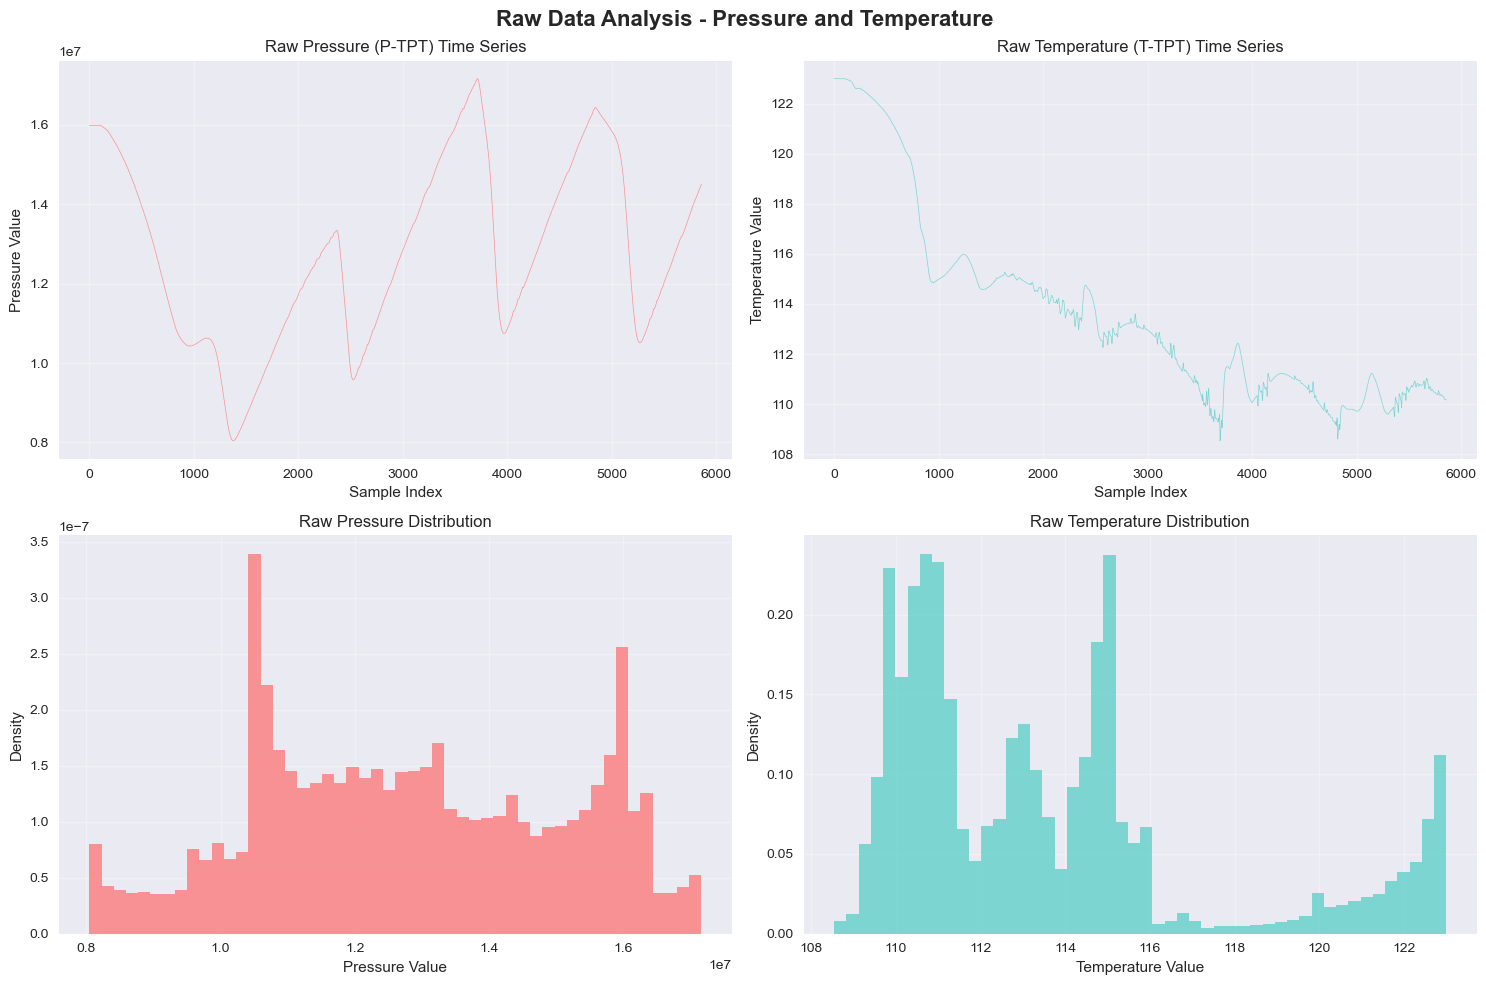

\n📈 Data Statistics:
Shape: (5860, 2)
              P-TPT        T-TPT
count  5.860000e+03  5860.000000
mean   1.279398e+07   113.602544
std    2.271296e+06     3.789139
min    8.045183e+06   108.539008
25%    1.088666e+07   110.678628
50%    1.266246e+07   112.789020
75%    1.476074e+07   115.021347
max    1.716205e+07   123.000196


In [4]:
# Step 3: Raw Data Analysis
print("📈 Step 3: Raw Data Analysis")
print("=" * config.SEPARATOR_LENGTH)

# Select random sample for detailed analysis using config values
try:
    idx, sample_df, class_label, sample_count = preprocessor.select_random_dataframe(
        filtered_dfs,
        filtered_classes,
        required_columns=config.REQUIRED_COLUMNS,
        min_samples=config.SAMPLE_ANALYSIS_MIN_SAMPLES,
    )

    print(f"🎯 Selected: DataFrame {idx + 1}, Class {class_label}")
    print(f"   Sample size: {sample_count} data points")
    print(f"   Using config: min_samples={config.SAMPLE_ANALYSIS_MIN_SAMPLES}")

    # Plot raw data analysis using config column names
    visualizer.plot_raw_data_analysis(
        sample_df, config.PRESSURE_COLUMN, config.TEMPERATURE_COLUMN
    )

except ValueError as e:
    print(f"⚠️ {e}")
    print("Using first available dataframe...")
    sample_df = filtered_dfs[0]
    class_label = filtered_classes[0]
    visualizer.plot_raw_data_analysis(
        sample_df, config.PRESSURE_COLUMN, config.TEMPERATURE_COLUMN
    )

## Raw Data Analysis

**Why analyze raw data?**
- **Baseline understanding** - See natural patterns and variations
- **Scale assessment** - Understand magnitude differences between features
- **Quality check** - Identify obvious issues before preprocessing

**Time series characteristics:**
- **Trends** - Long-term directional changes
- **Seasonality** - Periodic patterns  
- **Noise** - Random fluctuations that need filtering
- **Anomalies** - Unusual patterns indicating faults

## Data Scaling Theory

**Why scaling is crucial:**
- **Different scales** - Pressure (0-100 bar) vs Temperature (20-80°C)
- **Algorithm bias** - Distance-based algorithms favor larger-scale features
- **Gradient descent** - Converges faster with normalized inputs

**Common scaling methods:**
- **MinMax [0,1]** - Preserves relationships, good for bounded data
- **StandardScaler** - Centers data, good for normal distributions  
- **RobustScaler** - Less sensitive to outliers
- **MaxAbsScaler** - Preserves sparsity in data

**Choosing the right scaler depends on data distribution and algorithm requirements.**

⚙️ Step 4: Scaling Methods Comparison
📊 Scaling Results:

StandardScaler:
  Pressure - Range: [-2.0910, 1.9233]
  Temperature - Range: [-1.3364, 2.4804]

MinmaxScaler:
  Pressure - Range: [0.0000, 1.0000]
  Temperature - Range: [0.0000, 1.0000]

RobustScaler:
  Pressure - Range: [-1.1918, 1.1615]
  Temperature - Range: [-0.9787, 2.3513]

NormalizerScaler:
  Pressure - Range: [0.5517, 0.5954]
  Temperature - Range: [0.0000, 0.0000]
\n🔸 Plotting StandardScaler Analysis...


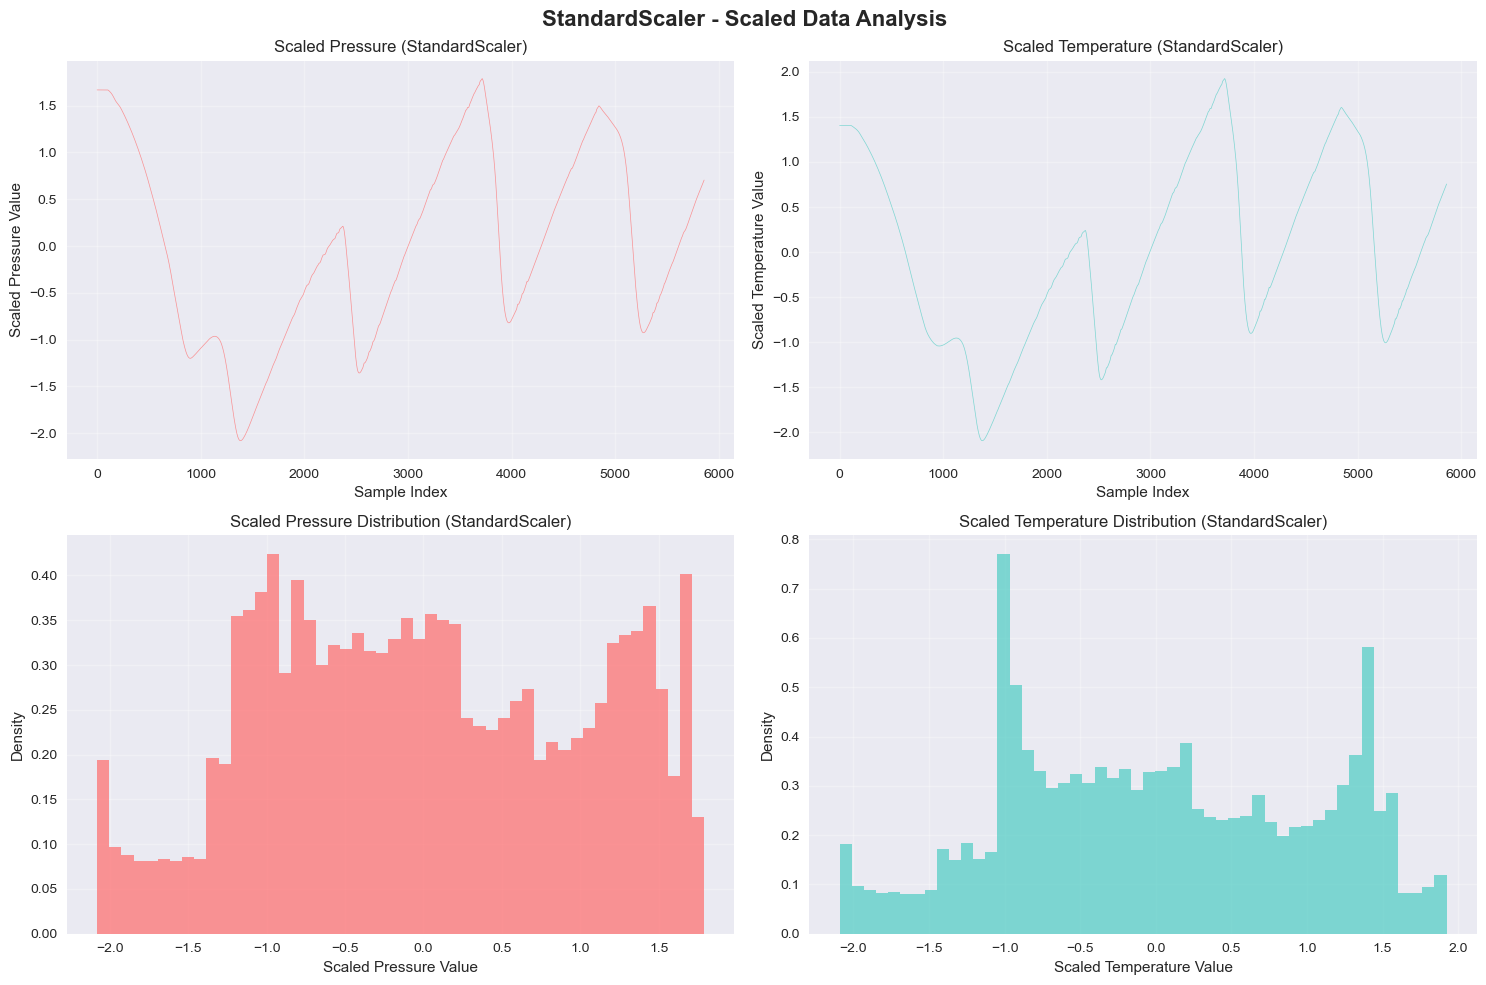

Statistics for StandardScaler:
Pressure - Mean: -0.0000, Std: 1.0001
Temperature - Mean: 0.0000, Std: 1.0001
\n🔸 Plotting MinmaxScaler Analysis...


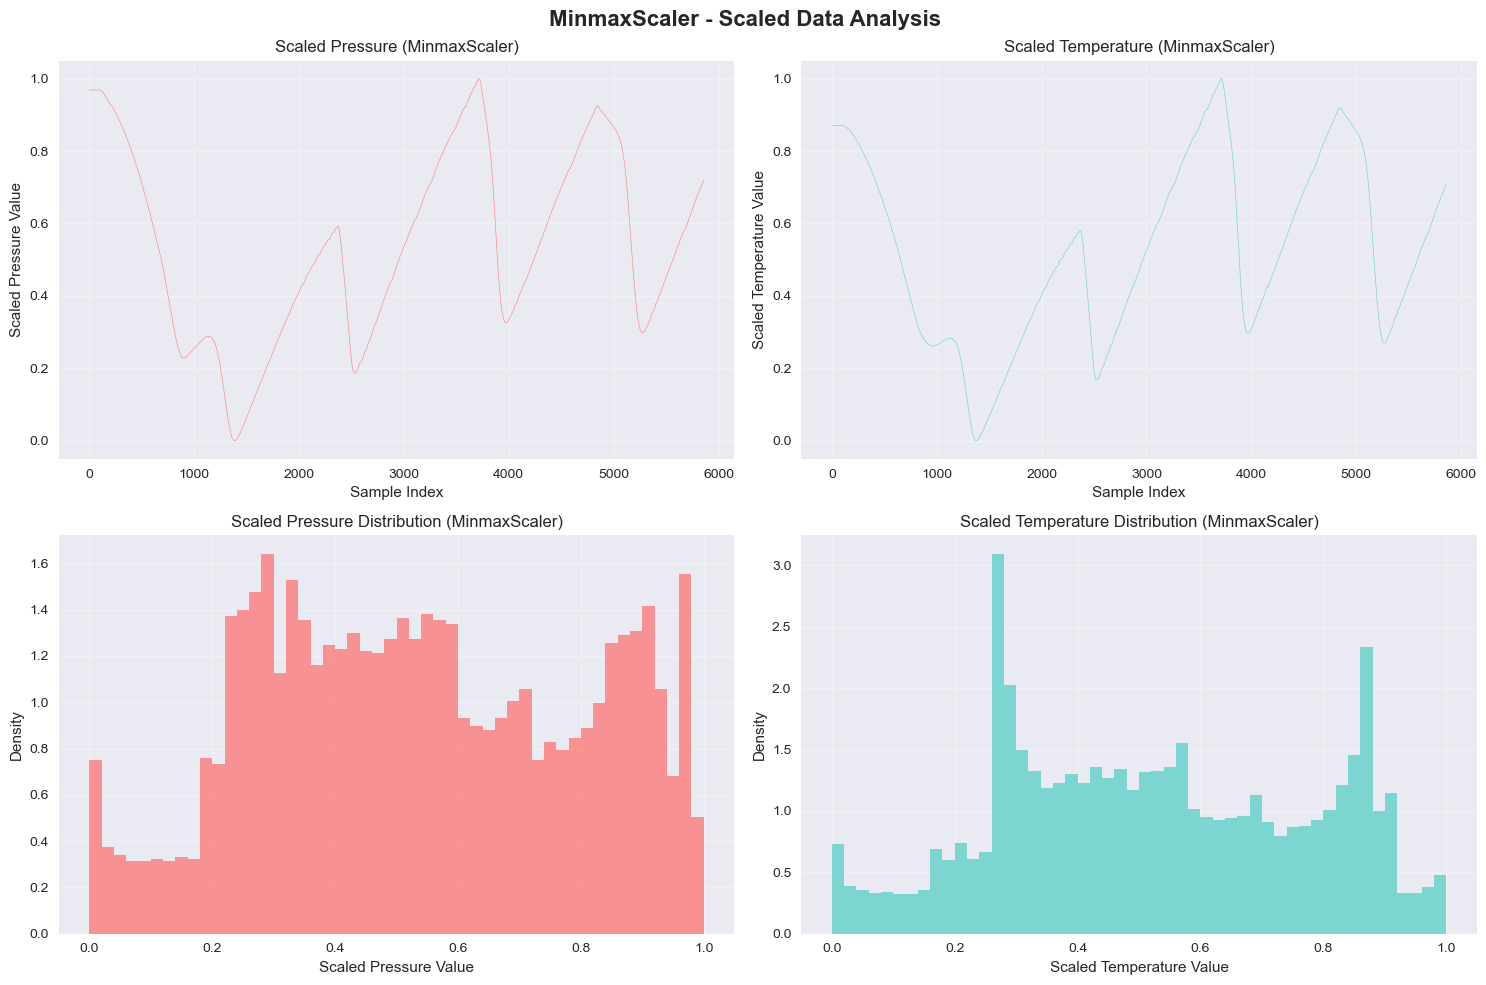

Statistics for MinmaxScaler:
Pressure - Mean: 0.5377, Std: 0.2585
Temperature - Mean: 0.5209, Std: 0.2491
\n🔸 Plotting RobustScaler Analysis...


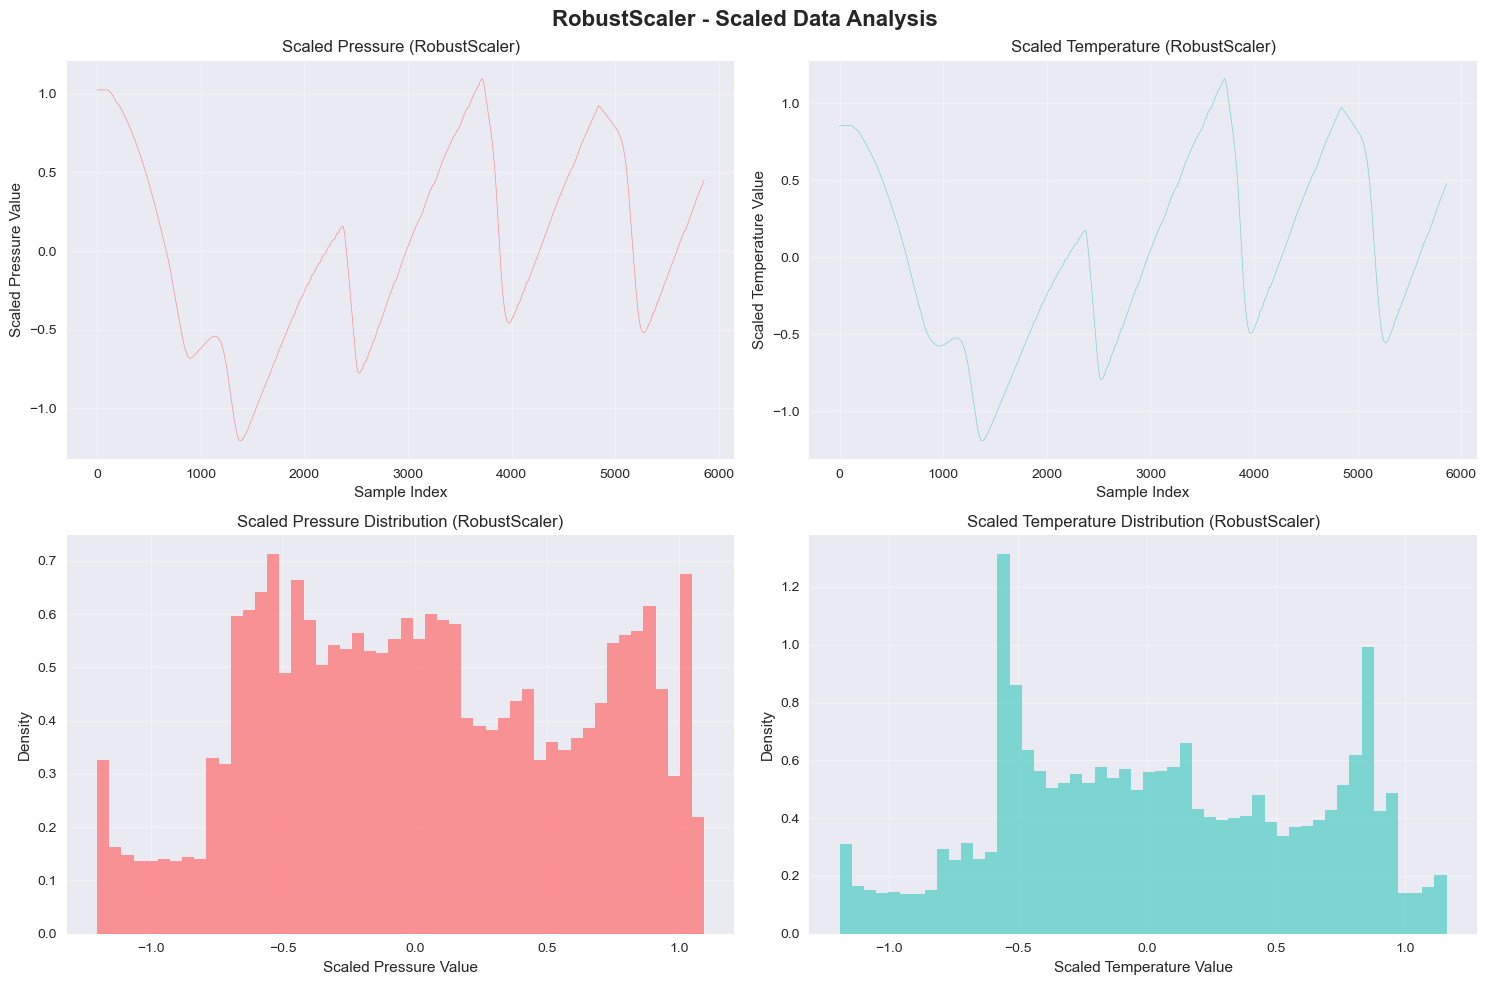

Statistics for RobustScaler:
Pressure - Mean: 0.0316, Std: 0.5948
Temperature - Mean: 0.0339, Std: 0.5863
\n🔸 Plotting NormalizerScaler Analysis...


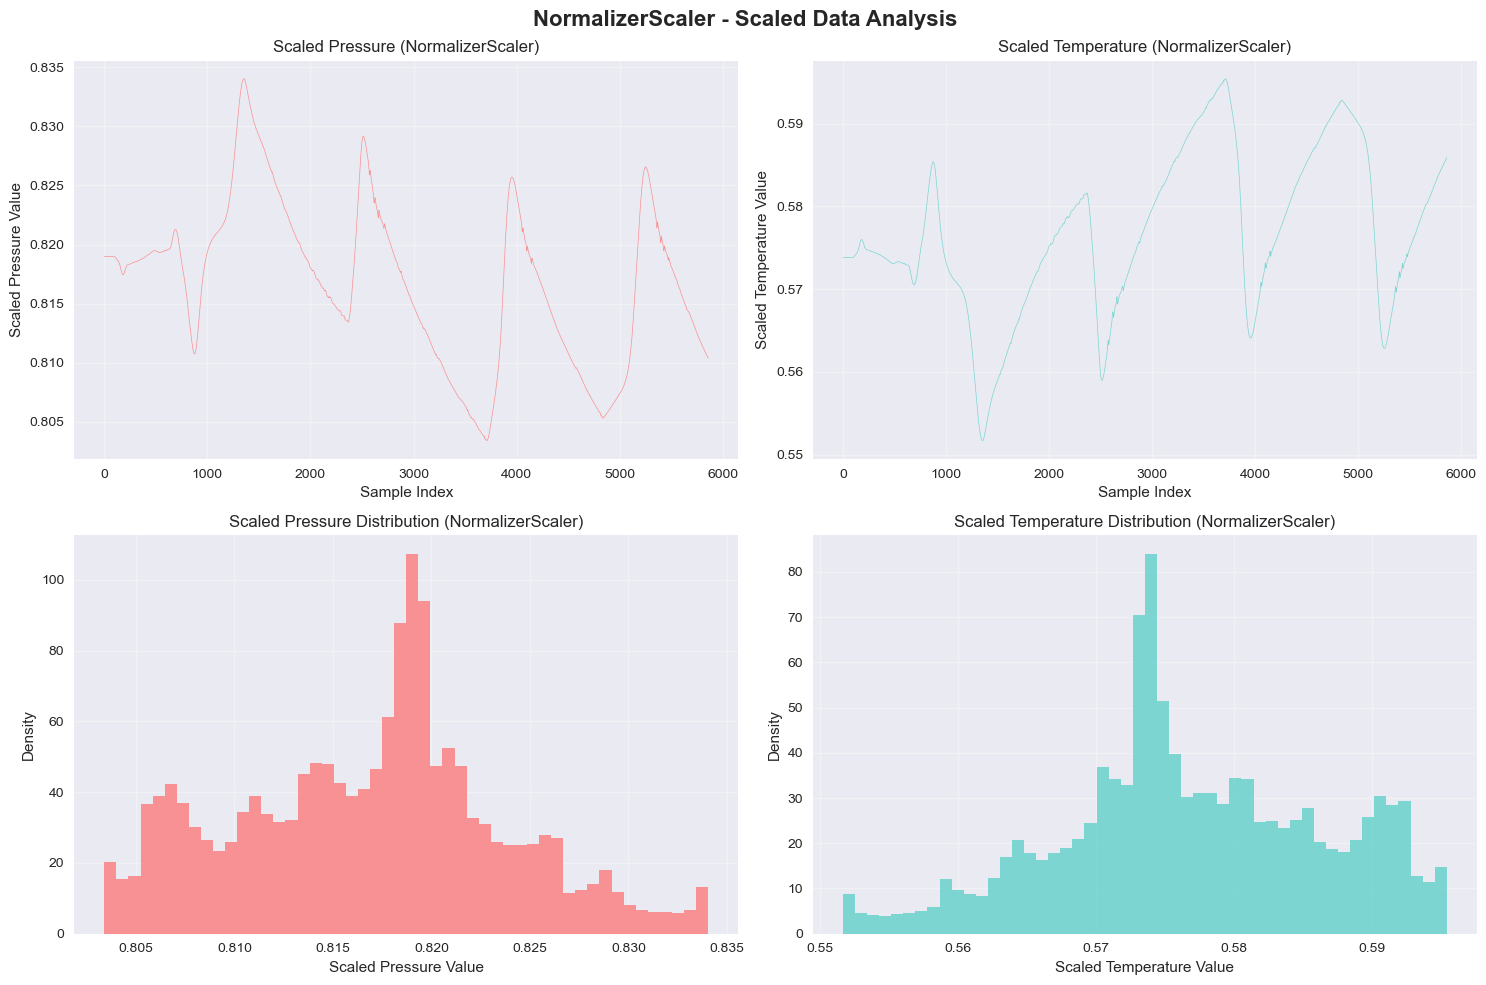

Statistics for NormalizerScaler:
Pressure - Mean: 0.8168, Std: 0.0068
Temperature - Mean: 0.5768, Std: 0.0096
\n🔸 Creating scaling comparison plots...


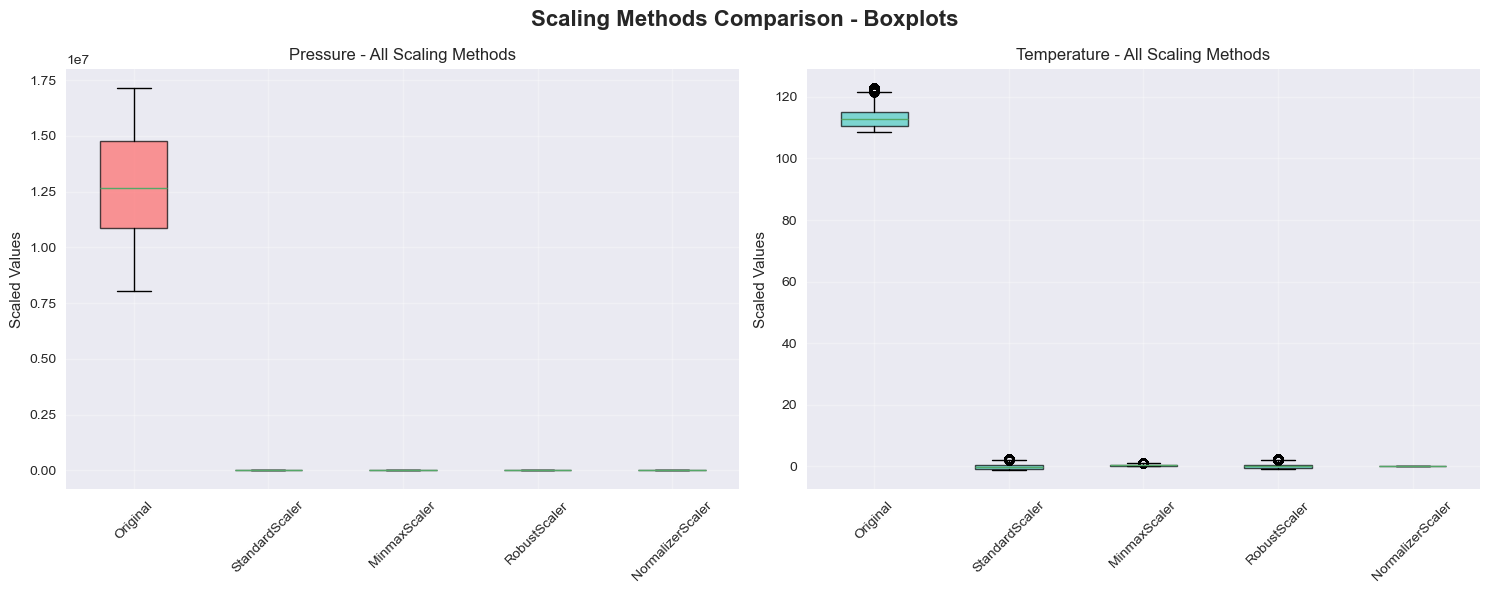

In [5]:
# Step 4: Scaling Methods Comparison
print("⚙️ Step 4: Scaling Methods Comparison")
print("=" * config.SEPARATOR_LENGTH)

# Apply all scaling methods to sample data
scaling_results = preprocessor.apply_multiple_scalers(sample_df)

# Display scaling statistics using config column names
print("📊 Scaling Results:")
for method_name, scaled_data in scaling_results.items():
    if method_name != "Original":
        numeric_cols = [
            col for col in scaled_data.columns if col != config.CLASS_COLUMN
        ]
        if numeric_cols:
            pressure_col = (
                [col for col in numeric_cols if config.PRESSURE_COLUMN in col][0]
                if any(config.PRESSURE_COLUMN in col for col in numeric_cols)
                else numeric_cols[0]
            )
            temp_col = (
                [col for col in numeric_cols if config.TEMPERATURE_COLUMN in col][0]
                if any(config.TEMPERATURE_COLUMN in col for col in numeric_cols)
                else numeric_cols[1] if len(numeric_cols) > 1 else numeric_cols[0]
            )

            print(f"\n{method_name}:")
            print(
                f"  Pressure - Range: [{scaled_data[pressure_col].min():.4f}, {scaled_data[pressure_col].max():.4f}]"
            )
            if pressure_col != temp_col:
                print(
                    f"  Temperature - Range: [{scaled_data[temp_col].min():.4f}, {scaled_data[temp_col].max():.4f}]"
                )

# Visualize each scaling method
for method_name, scaled_data in scaling_results.items():
    if method_name != "Original":
        visualizer.plot_scaled_data_analysis(scaled_data, method_name)

# Create comparison plot using config column names
visualizer.plot_scaling_comparison(
    scaling_results, config.PRESSURE_COLUMN, config.TEMPERATURE_COLUMN
)

## Apply Default Scaler

Apply configured scaling method to all data.

**Implementation strategy:**
- **Consistent application** - Same scaler for all data splits
- **Avoid data leakage** - Scale training and test independently in real scenarios
- **Validation** - Check scaling worked correctly

**Best practices:**
- **Fit on training data only** (in production)
- **Transform both train and test** with same scaler
- **Store scaler parameters** for inference

In [6]:
# Step 5: Apply MinMax Scaling to All Data
print("🔄 Step 5: Processing All Data with Configured Scaler")
print("=" * config.SEPARATOR_LENGTH)

# Apply scaling using config method
scaling_method = config.DEFAULT_SCALING_METHOD
print(f"📋 Using scaling method from config: {scaling_method}")

normalized_dfs, normalized_classes = preprocessor.apply_scaling(
    filtered_dfs, filtered_classes, method=scaling_method
)

# Validation
if normalized_dfs:
    sample_normalized = normalized_dfs[0]
    validation_results = preprocessor.validate_scaling(
        sample_normalized, scaling_method
    )

    print(f"\n✅ Successfully normalized {len(normalized_dfs)} dataframes")
    print(f"📊 Sample normalized data shape: {sample_normalized.shape}")
    print(
        f"🔍 Validation results: {all(validation_results['correct_scaling'].values())}"
    )
    print(f"⚙️ Scaling method applied: {scaling_method}")

    # Show sample of normalized data
    print(f"\n📋 Sample Normalized Data (first 3 rows):")
    print(sample_normalized.head(3))

    print(f"\n💾 Variables created:")
    print(f"   • normalized_dfs: {len(normalized_dfs)} normalized dataframes")
    print(f"   • normalized_classes: corresponding class labels")
    print(f"   • Scaling method: {scaling_method} (from config)")

else:
    print("❌ No data was successfully normalized")

🔄 Step 5: Processing All Data with Configured Scaler
📋 Using scaling method from config: minmax
🔄 Applying MinmaxScaler to All Dataframes
✅ DataFrame 1 (Class 0):
   Original shape: (3575, 4)
   Scaled shape: (3575, 4)
   Numeric columns scaled: ['P-PDG', 'P-TPT', 'T-TPT']
   Value ranges after scaling:
     P-PDG_scaled: [0.0000, 0.0000]
     P-TPT_scaled: [0.0000, 1.0000]
     T-TPT_scaled: [0.0000, 1.0000]

✅ DataFrame 2 (Class 0):
   Original shape: (3586, 4)
   Scaled shape: (3586, 4)
   Numeric columns scaled: ['P-PDG', 'P-TPT', 'T-TPT']
   Value ranges after scaling:
     P-PDG_scaled: [0.0000, 0.0000]
     P-TPT_scaled: [0.0000, 1.0000]
     T-TPT_scaled: [0.0000, 1.0000]

✅ DataFrame 3 (Class 0):
   Original shape: (3584, 4)
   Scaled shape: (3584, 4)
   Numeric columns scaled: ['P-PDG', 'P-TPT', 'T-TPT']
   Value ranges after scaling:
     P-PDG_scaled: [0.0000, 0.0000]
     P-TPT_scaled: [0.0000, 1.0000]
     T-TPT_scaled: [0.0000, 1.0000]

✅ DataFrame 4 (Class 0):
   Origin

In [7]:
# Summary
print("📋 Summary & Scaling Methods Guide")
print("=" * 45)

# Print comprehensive scaling summary
visualizer.print_scaling_summary()

print(f"🎉 Processing Complete!")
print(
    f"✅ Loaded and processed {len(normalized_dfs) if 'normalized_dfs' in locals() else 0} dataframes"
)
print(f"📊 Data ready for machine learning algorithms")

print(f"🔧 Available Variables:")
print(f"   • filtered_dfs: Original filtered data")
print(f"   • normalized_dfs: MinMax scaled data [0,1]")
print(f"   • scaling_results: Comparison of all scaling methods")

📋 Summary & Scaling Methods Guide
\n📋 Scaling Methods Summary:
🔹 StandardScaler: Mean=0, Std=1 (assumes normal distribution)
🔹 MinMaxScaler: Scales to [0,1] range (preserves relationships)
🔹 RobustScaler: Uses median and IQR (robust to outliers)
🔹 Normalizer: Unit vector scaling (preserves direction)
\n💡 When to use each:
- StandardScaler: Normal data, algorithms that assume normality (SVM, Neural Networks)
- MinMaxScaler: Need bounded values, preserve zero, distance-based algorithms
- RobustScaler: Data with outliers, non-normal distributions
- Normalizer: When direction matters more than magnitude (text analysis, clustering)
🎉 Processing Complete!
✅ Loaded and processed 400 dataframes
📊 Data ready for machine learning algorithms
🔧 Available Variables:
   • filtered_dfs: Original filtered data
   • normalized_dfs: MinMax scaled data [0,1]
   • scaling_results: Comparison of all scaling methods


## Cross-Validation Theory

**Why cross-validation?**
- **Model generalization** - Ensure performance on unseen data
- **Avoiding overfitting** - Test on multiple data splits
- **Robust evaluation** - Average performance across folds

**Special considerations for time series:**
- **Temporal order** - Can't randomly shuffle time-dependent data
- **Real vs simulated** - Different data characteristics require careful splitting
- **Realistic evaluation** - Test on real data, train on both real + simulated

**3W Strategy:**
- **Training set** - All available data (real + simulated)
- **Test set** - Real data only (more challenging, realistic)
- **Cross-validation** - Multiple folds for robust estimates

In [8]:
# ============================================================
# STEP 5: SMART TRAIN-TEST SPLIT WITH 3-FOLD CROSS-VALIDATION
# ============================================================
print("=" * config.HEADER_SEPARATOR_LENGTH)
print("STEP 5: SMART TRAIN-TEST SPLIT WITH 3-FOLD CROSS-VALIDATION")
print("=" * config.HEADER_SEPARATOR_LENGTH)

# ============================================================
# Step 5a: Initialize Cross-Validation System
# ============================================================
print("🔧 Step 5a: Initializing Cross-Validation System")
print("-" * config.SEPARATOR_LENGTH)

# Initialize the cross-validator using config values
print(f"📋 Cross-validation configuration:")
print(f"   • Number of folds: {config.N_FOLDS}")
print(f"   • Random state: {config.CV_RANDOM_STATE}")
print(f"   • Verbose mode: {config.CV_VERBOSE}")

cross_validator = CrossValidator(
    n_folds=config.N_FOLDS,
    random_state=config.CV_RANDOM_STATE,
    verbose=config.CV_VERBOSE,
)

STEP 5: SMART TRAIN-TEST SPLIT WITH 3-FOLD CROSS-VALIDATION
🔧 Step 5a: Initializing Cross-Validation System
--------------------------------------------------
📋 Cross-validation configuration:
   • Number of folds: 3
   • Random state: 42
   • Verbose mode: False


## Cross-Validation Implementation

**Fold creation process:**
1. **Data separation** - Split real vs simulated data
2. **Stratification** - Ensure balanced class distribution
3. **Validation** - Check fold quality and balance

**Key metrics to monitor:**
- **Class balance** across folds
- **Real/simulated ratio** in training sets
- **Sample sizes** for statistical significance

In [9]:
# ============================================================
# Step 5b: Set Up Cross-Validation Folds
# ============================================================
print("\n🔧 Step 5b: Setting Up Cross-Validation Folds")
print("-" * config.SEPARATOR_LENGTH)

try:
    # Set up complete cross-validation in one call
    cv_folds, separated_data = cross_validator.setup_complete_cv(
        dfs=normalized_dfs, classes=normalized_classes, loader=loader
    )

    # Extract separated data for convenience
    real_dfs, real_classes, simulated_dfs, simulated_classes = separated_data

    print(f"✅ Cross-validation setup complete!")
    print(f"   • Created {len(cv_folds)} cross-validation folds")
    print(f"   • Real data: {len(real_dfs)} samples")
    print(f"   • Simulated data: {len(simulated_dfs)} samples")

except Exception as e:
    print(f"❌ Error during cross-validation setup: {e}")
    raise


🔧 Step 5b: Setting Up Cross-Validation Folds
--------------------------------------------------

📊 Cross-Validation Summary:
Dataset Overview:
   • Total real samples: 227
   • Total simulated samples: 173
   • Number of folds: 3

Per-Fold Averages:
   • Avg real samples for training: 151.3
   • Avg simulated samples for training: 173 (constant)
   • Avg real samples for testing: 75.7
   • Avg train/test ratio: 66.7% / 33.3%

Validation:
   • Test coverage: 227 total assignments across folds
   • Unique test samples: 227
   • Each real sample tested exactly once: ✅

💾 Variables Created:
   • cv_folds: List of 3 cross-validation fold dictionaries
   • Each fold contains train_dfs, test_dfs, train_classes, test_classes

🎯 Ready for 3-fold cross-validation training and evaluation!
✅ Cross-validation setup complete!
   • Created 3 cross-validation folds
   • Real data: 227 samples
   • Simulated data: 173 samples


In [10]:
# ============================================================
# Step 5c: Fold Analysis and Statistics
# ============================================================
print("\n📊 Step 5c: Analyzing Cross-Validation Folds")
print("-" * config.SEPARATOR_LENGTH)

# Quick fold analysis with reduced verbosity
print(f"🔄 Analyzing {len(cv_folds)} folds...")

for fold_num in range(1, len(cv_folds) + 1):
    fold = cv_folds[fold_num - 1]

    train_count = len(fold["train_dfs"])
    test_count = len(fold["test_dfs"])
    train_real = fold["train_real_count"]
    train_sim = fold["train_sim_count"]

    print(
        f"   📁 Fold {fold_num}: {train_count} train ({train_real}R+{train_sim}S), {test_count} test"
    )

print(f"\n✅ All folds ready for model training!")


📊 Step 5c: Analyzing Cross-Validation Folds
--------------------------------------------------
🔄 Analyzing 3 folds...
   📁 Fold 1: 324 train (151R+173S), 76 test
   📁 Fold 2: 324 train (151R+173S), 76 test
   📁 Fold 3: 325 train (152R+173S), 75 test

✅ All folds ready for model training!


In [11]:
# ============================================================
# Step 5d: Cross-Validation Ready for Model Training
# ============================================================
print(f"\n🚀 Step 5d: Cross-Validation System Ready!")
print("=" * 50)

# Create convenient access variables for default fold (Fold 1)
fold_1_data = cv_folds[0]
train_dfs = fold_1_data["train_dfs"]
train_classes = fold_1_data["train_classes"]
test_dfs = fold_1_data["test_dfs"]
test_classes = fold_1_data["test_classes"]

print(f"💾 Key variables created:")
print(f"   • cv_folds: {len(cv_folds)} cross-validation folds")
print(f"   • cross_validator: CrossValidator instance with utility methods")
print(f"   • train_dfs, test_dfs: Default fold (Fold 1) for immediate use")
print(f"   • real_dfs, simulated_dfs: Separated data for advanced usage")

print(f"\n⚡ Performance optimized for fast model training!")


🚀 Step 5d: Cross-Validation System Ready!
💾 Key variables created:
   • cv_folds: 3 cross-validation folds
   • cross_validator: CrossValidator instance with utility methods
   • train_dfs, test_dfs: Default fold (Fold 1) for immediate use
   • real_dfs, simulated_dfs: Separated data for advanced usage

⚡ Performance optimized for fast model training!


In [12]:
# ============================================================
# Step 5d: Cross-Validation Usage Examples
# ============================================================
print("🛠️ Cross-Validation Usage Examples")
print("=" * 40)

print("📚 Available CrossValidator Methods:")
print("   • setup_complete_cv() - Complete setup in one call")
print("   • separate_real_simulated_data() - Separate data types")
print("   • create_cv_folds() - Create cross-validation folds")
print("   • get_fold_data() - Get specific fold data")
print("   • print_fold_summary() - Print detailed fold info")
print("   • compare_all_folds() - Compare all folds")
print("   • print_cv_summary() - Print overall summary")

print("\n🎯 Example Usage:")
print("# Get data for fold 2:")
print(
    "train_dfs_2, train_classes_2, test_dfs_2, test_classes_2 = cross_validator.get_fold_data(2, cv_folds)"
)

print("\n# Print detailed summary for fold 3:")
print("cross_validator.print_fold_summary(3, cv_folds)")

print("\n# Compare all folds:")
print("cross_validator.compare_all_folds(cv_folds)")

# Demonstrate accessing fold 2 data
if len(cv_folds) >= 2:
    print(f"\n🔍 Demonstrating fold 2 access:")
    fold_2_train_dfs, fold_2_train_classes, fold_2_test_dfs, fold_2_test_classes = (
        cross_validator.get_fold_data(2, cv_folds)
    )
    print(f"   • Fold 2 training samples: {len(fold_2_train_dfs)}")
    print(f"   • Fold 2 test samples: {len(fold_2_test_dfs)}")

print(
    f"\n✅ All cross-validation methods are now organized in the CrossValidator class!"
)
print(f"   Located in: src/cross_validation.py")
print(f"   Clean, reusable, and well-documented code structure")

🛠️ Cross-Validation Usage Examples
📚 Available CrossValidator Methods:
   • setup_complete_cv() - Complete setup in one call
   • separate_real_simulated_data() - Separate data types
   • create_cv_folds() - Create cross-validation folds
   • get_fold_data() - Get specific fold data
   • print_fold_summary() - Print detailed fold info
   • compare_all_folds() - Compare all folds
   • print_cv_summary() - Print overall summary

🎯 Example Usage:
# Get data for fold 2:
train_dfs_2, train_classes_2, test_dfs_2, test_classes_2 = cross_validator.get_fold_data(2, cv_folds)

# Print detailed summary for fold 3:
cross_validator.print_fold_summary(3, cv_folds)

# Compare all folds:
cross_validator.compare_all_folds(cv_folds)

🔍 Demonstrating fold 2 access:
   • Fold 2 training samples: 324
   • Fold 2 test samples: 76

✅ All cross-validation methods are now organized in the CrossValidator class!
   Located in: src/cross_validation.py
   Clean, reusable, and well-documented code structure


## Time Windowing Theory

**Why windowing for time series?**
- **Sequential dependencies** - Capture temporal patterns and trends
- **Fixed input size** - Most ML algorithms require consistent input dimensions
- **Pattern recognition** - Enable detection of temporal fault signatures

**Windowing parameters:**
- **Window size** - How much history to include (e.g., 100 time steps)
- **Stride** - Step size between windows (overlapping vs non-overlapping)
- **Minimum size** - Reject windows that are too small

**Benefits:**
- **LSTM/RNN compatibility** - Sequential models need windowed data
- **Pattern extraction** - Capture fault development over time
- **Data augmentation** - Generate more training samples from limited data

**Trade-offs:**
- **Larger windows** - More context but higher memory usage
- **Smaller stride** - More samples but increased correlation between windows

In [13]:
# ============================================================
# STEP 6: ADVANCED WINDOWING WITH CROSS-VALIDATION
# ============================================================
print("=" * config.HEADER_SEPARATOR_LENGTH)
print("STEP 6: ADVANCED WINDOWING WITH CROSS-VALIDATION")
print("=" * config.HEADER_SEPARATOR_LENGTH)

# Define windowing parameters from config
try:
    window_size = config.WINDOW_SIZE
    stride = config.WINDOW_STRIDE
    min_window_size = config.MIN_WINDOW_SIZE
    print(f"✅ Windowing parameters loaded from config")
except AttributeError as e:
    # Fallback values if not in config
    window_size = 100
    stride = 50
    min_window_size = 50
    print(f"⚠️ Using fallback windowing parameters: {e}")

# Initialize storage for all windowed folds
all_windowed_folds = []
total_train_windows = 0
total_test_windows = 0

print(f"🔧 Windowing Configuration:")
print(f"   • Window size: {window_size} samples")
print(f"   • Stride: {stride} samples")
print(f"   • Min window size: {min_window_size} samples")

# Process each cross-validation fold with enhanced progress tracking
print(f"\n🔄 Processing {len(cv_folds)} folds...")

for i, fold in enumerate(cv_folds):
    fold_num = fold["fold_number"]

    # Get fold data
    fold_train_dfs = fold["train_dfs"]
    fold_train_classes = fold["train_classes"]
    fold_test_dfs = fold["test_dfs"]
    fold_test_classes = fold["test_classes"]

    # Show progress before processing
    print(
        f"   🔄 Processing Fold {fold_num}... ({len(fold_train_dfs)} train + {len(fold_test_dfs)} test samples)"
    )

    # Apply windowing to this fold
    fold_windowing_results = preprocessor.apply_windowing_to_split(
        train_dfs=fold_train_dfs,
        test_dfs=fold_test_dfs,
        train_classes=fold_train_classes,
        test_classes=fold_test_classes,
        window_size=window_size,
        stride=stride,
        min_window_size=min_window_size,
    )

    # Store windowed results for this fold
    windowed_fold = {
        "fold_number": fold_num,
        "original_fold": fold,
        "windowing_results": fold_windowing_results,
        "train_windowed_dfs": fold_windowing_results["train_windowed_dfs"],
        "train_windowed_classes": fold_windowing_results["train_windowed_classes"],
        "test_windowed_dfs": fold_windowing_results["test_windowed_dfs"],
        "test_windowed_classes": fold_windowing_results["test_windowed_classes"],
    }

    all_windowed_folds.append(windowed_fold)

    # Update totals
    fold_train_windows = len(fold_windowing_results["train_windowed_dfs"])
    fold_test_windows = len(fold_windowing_results["test_windowed_dfs"])
    total_train_windows += fold_train_windows
    total_test_windows += fold_test_windows

    print(
        f"   📁 Fold {fold_num}: {fold_train_windows} train, {fold_test_windows} test windows ✅"
    )

print(f"\n📊 Windowing Complete:")
print(f"   • Total training windows: {total_train_windows:,}")
print(f"   • Total test windows: {total_test_windows:,}")
print(
    f"   • Average per fold: {total_train_windows//len(cv_folds):,} train, {total_test_windows//len(cv_folds):,} test"
)

# Set default fold windowing results for compatibility (Fold 1)
windowing_results = all_windowed_folds[0]["windowing_results"]
train_windowed_dfs = all_windowed_folds[0]["train_windowed_dfs"]
train_windowed_classes = all_windowed_folds[0]["train_windowed_classes"]
test_windowed_dfs = all_windowed_folds[0]["test_windowed_dfs"]
test_windowed_classes = all_windowed_folds[0]["test_windowed_classes"]

print(f"\n✅ Default variables set to Fold 1 for compatibility")

STEP 6: ADVANCED WINDOWING WITH CROSS-VALIDATION
✅ Windowing parameters loaded from config
🔧 Windowing Configuration:
   • Window size: 300 samples
   • Stride: 150 samples
   • Min window size: 300 samples

🔄 Processing 3 folds...
   🔄 Processing Fold 1... (324 train + 76 test samples)
🔄 Applying windowing to train/test split...

📚 Processing training data:
🪟 Creating time windows:
   Window size: 300
   Stride: 150
   Minimum window size: 300
----------------------------------------
✅ Sample 1 (class 0): 22 windows from 3586 points
✅ Sample 2 (class 0): 22 windows from 3584 points
✅ Sample 3 (class 0): 22 windows from 3562 points
✅ Sample 4 (class 0): 22 windows from 3571 points
✅ Sample 5 (class 0): 22 windows from 3556 points
✅ Sample 6 (class 0): 22 windows from 3569 points
✅ Sample 7 (class 0): 22 windows from 3579 points
✅ Sample 8 (class 0): 22 windows from 3573 points
✅ Sample 9 (class 0): 22 windows from 3573 points
✅ Sample 10 (class 0): 22 windows from 3594 points
✅ Sample 

## Windowing Implementation

**Process overview:**
1. **Apply to each CV fold** - Maintain fold integrity
2. **Generate windows** with specified size and stride
3. **Quality control** - Remove windows below minimum size
4. **Statistics tracking** - Monitor window counts and distributions

**Output structure:**
- **Windowed dataframes** - 3D arrays suitable for sequence models
- **Preserved labels** - Class information maintained for each window
- **Metadata** - Information about windowing process for each sample


📈 Creating Windowing Visualizations (Fold 1 Sample)
--------------------------------------------------


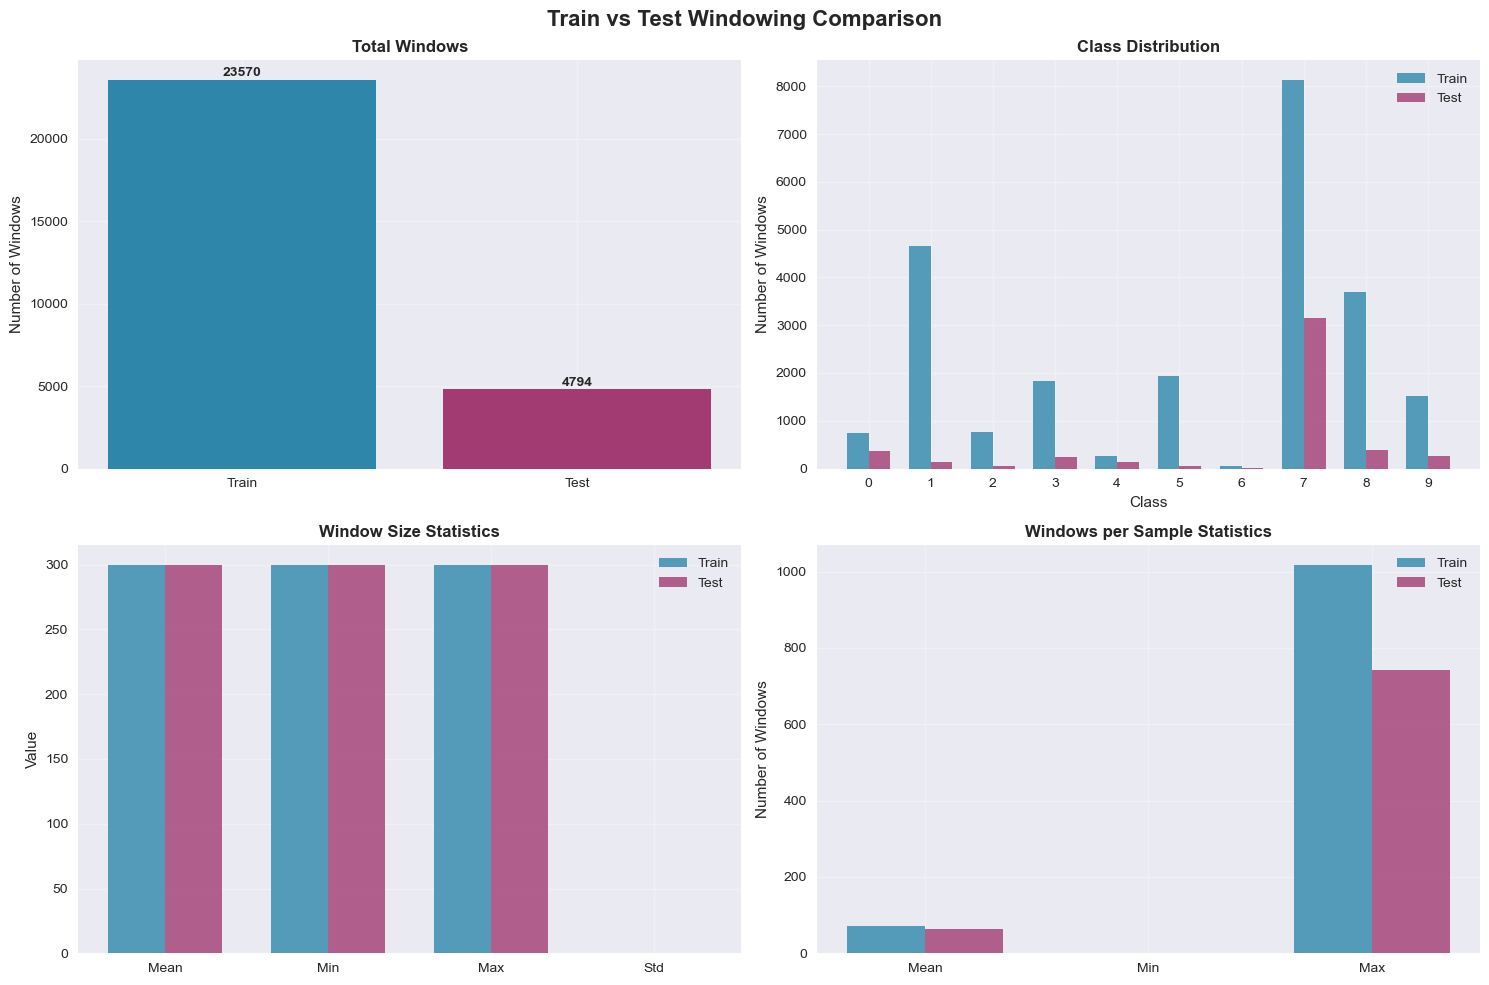

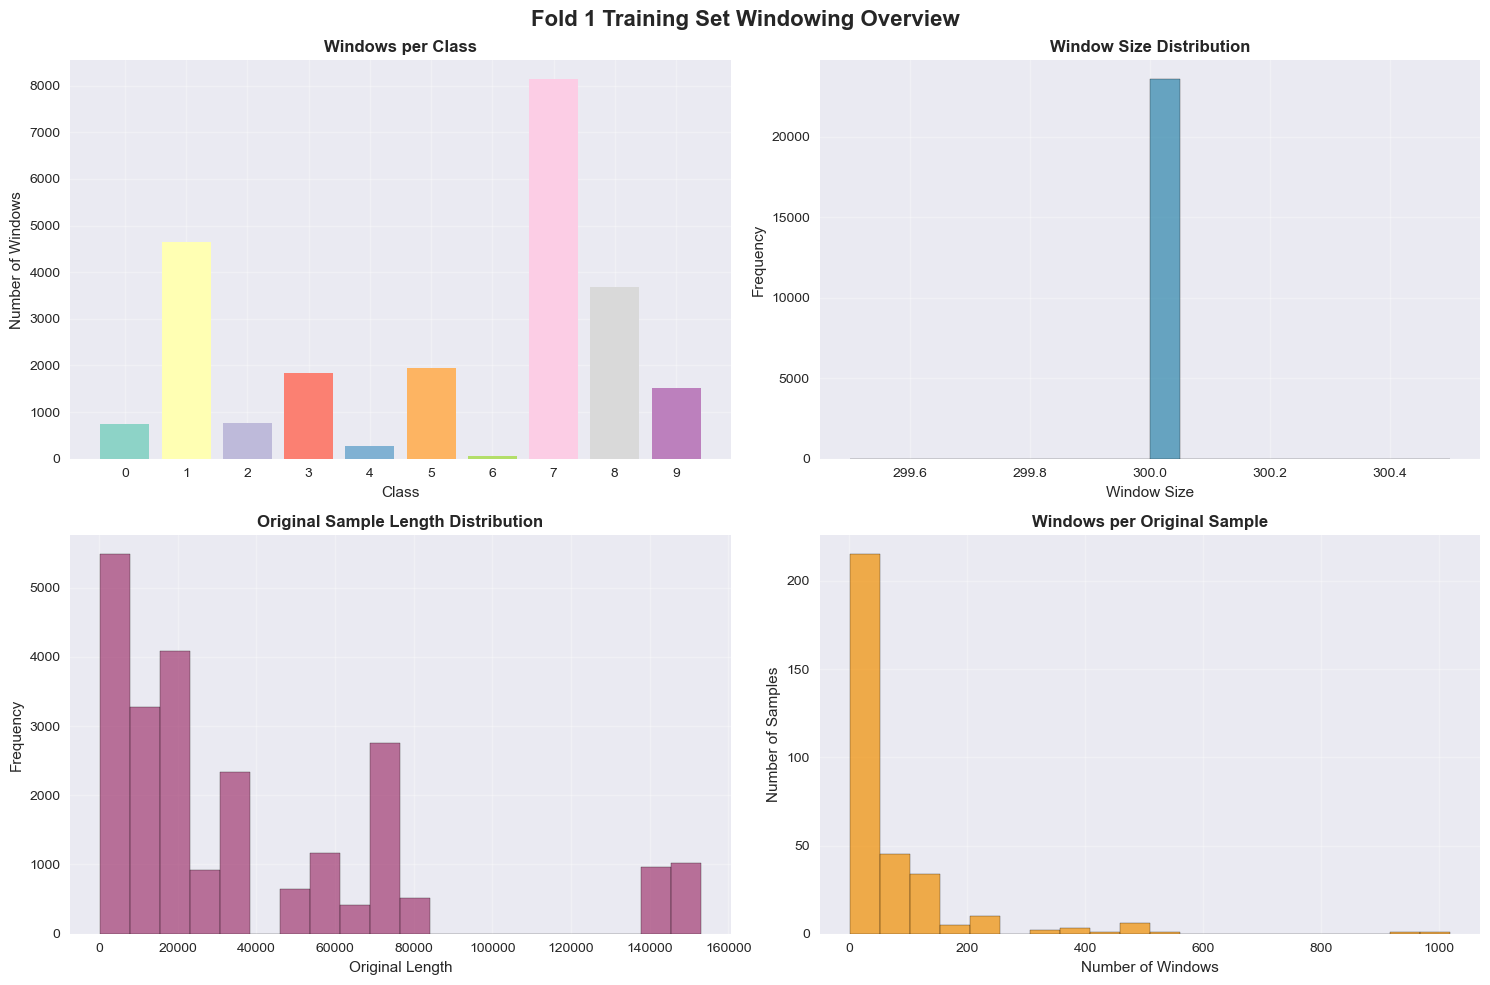

✅ Visualization complete


In [14]:
# Visualize windowing results from Fold 1 (sample)
print("\n📈 Creating Windowing Visualizations (Fold 1 Sample)")
print("-" * config.SEPARATOR_LENGTH)

try:
    # Get Fold 1 data for visualization
    fold_1_data = all_windowed_folds[0]
    fold_1_windowing = fold_1_data["windowing_results"]

    # Plot windowing comparison between train and test for Fold 1
    visualizer.plot_windowing_comparison(
        fold_1_windowing["train_statistics"], fold_1_windowing["test_statistics"]
    )

    # Show windowing overview for Fold 1 training data (if metadata exists)
    fold_1_train_metadata = fold_1_windowing.get("train_metadata", [])
    if fold_1_train_metadata:
        visualizer.plot_windowing_overview(
            fold_1_train_metadata, "Fold 1 Training Set Windowing Overview"
        )
    else:
        print("ℹ️  No metadata available for detailed windowing overview")

    print("✅ Visualization complete")

except Exception as e:
    print(f"⚠️  Visualization error: {e}")
    print("Continuing without visualization...")

## Data Persistence Theory

**Why save processed data?**
- **Reproducibility** - Ensure consistent preprocessing across experiments
- **Efficiency** - Avoid reprocessing for multiple training runs
- **Collaboration** - Share processed data with team members
- **Version control** - Track preprocessing parameters and configurations

**Best practices:**
- **Comprehensive metadata** - Save all preprocessing parameters
- **Cross-validation integrity** - Maintain fold structure
- **Format efficiency** - Use appropriate serialization (pickle, HDF5, etc.)
- **Documentation** - Include processing timestamps and configurations

In [15]:
# ============================================================
# STEP 7: SAVE PROCESSED DATA FOR MODEL TRAINING
# ============================================================
import pandas as pd

print("=" * config.HEADER_SEPARATOR_LENGTH)
print("STEP 7: SAVE PROCESSED DATA FOR MODEL TRAINING")
print("=" * config.HEADER_SEPARATOR_LENGTH)

# Check windowing results structure first
print("🔍 Checking windowing results structure...")
if all_windowed_folds:
    sample_fold = all_windowed_folds[0]
    print(f"Sample fold keys: {list(sample_fold.keys())}")
    if "windowing_results" in sample_fold:
        windowing_keys = list(sample_fold["windowing_results"].keys())
        print(f"Windowing results keys: {windowing_keys}")

    # Fix missing statistics - add them to the fold_data level (not just windowing_results)
    for i, fold_data in enumerate(all_windowed_folds):
        fold_results = fold_data["windowing_results"]

        # Create statistics if they don't exist in windowing_results
        if "train_statistics" not in fold_results:
            fold_results["train_statistics"] = {
                "total_windows": len(fold_data["train_windowed_dfs"]),
                "total_samples": (
                    sum(len(df) for df in fold_data["train_windowed_dfs"])
                    if fold_data["train_windowed_dfs"]
                    else 0
                ),
            }

        if "test_statistics" not in fold_results:
            fold_results["test_statistics"] = {
                "total_windows": len(fold_data["test_windowed_dfs"]),
                "total_samples": (
                    sum(len(df) for df in fold_data["test_windowed_dfs"])
                    if fold_data["test_windowed_dfs"]
                    else 0
                ),
            }

        # IMPORTANT: Also add statistics directly to fold_data level for save function
        fold_data["train_statistics"] = fold_results["train_statistics"]
        fold_data["test_statistics"] = fold_results["test_statistics"]

        # Add missing metadata fields
        if "train_metadata" not in fold_data:
            fold_data["train_metadata"] = []
        if "test_metadata" not in fold_data:
            fold_data["test_metadata"] = []

        # Update the fold data with fixed results
        all_windowed_folds[i] = fold_data

    print("✅ Fixed missing statistics and metadata in windowing results")

# Create comprehensive results structure
extended_windowing_results = {
    "all_windowed_folds": all_windowed_folds,
    "total_train_windows": total_train_windows,
    "total_test_windows": total_test_windows,
    "window_config": {
        "window_size": window_size,
        "stride": stride,
        "min_window_size": min_window_size,
    },
    "fold_count": len(cv_folds),
}

print(f"📋 Preparing to save:")
print(f"   • CV folds: {len(cv_folds)}")
print(f"   • Windowed folds: {len(all_windowed_folds)}")
print(f"   • Total windows: {total_train_windows + total_test_windows:,}")
print(f"   • Format: {config.SAVE_FORMAT}")
print(f"   • Directory: {config.PROCESSED_DATA_DIR}")

# Configure save directory
save_dir = config.PROCESSED_DATA_DIR
print(f"\n💾 Saving to: {save_dir}")

processing_config = {
    "sampling_rate": config.SAMPLING_RATE,
    "window_size": window_size,
    "stride": stride,
    "n_folds": config.N_FOLDS,
    "scaling_method": scaling_method,
    "save_format": config.SAVE_FORMAT,
    "processed_timestamp": str(pd.Timestamp.now()),
}

STEP 7: SAVE PROCESSED DATA FOR MODEL TRAINING
🔍 Checking windowing results structure...
Sample fold keys: ['fold_number', 'original_fold', 'windowing_results', 'train_windowed_dfs', 'train_windowed_classes', 'test_windowed_dfs', 'test_windowed_classes']
Windowing results keys: ['train_windowed_dfs', 'train_windowed_classes', 'train_metadata', 'test_windowed_dfs', 'test_windowed_classes', 'test_metadata', 'train_statistics', 'test_statistics', 'windowing_parameters']
✅ Fixed missing statistics and metadata in windowing results
📋 Preparing to save:
   • CV folds: 3
   • Windowed folds: 3
   • Total windows: 85,092
   • Format: pickle
   • Directory: processed_data

💾 Saving to: processed_data


## Saving Implementation

**What gets saved:**
- **Cross-validation folds** - All train/test splits with metadata
- **Windowed data** - Time series windows ready for sequence models  
- **Processing configuration** - All parameters for reproducibility
- **Statistics** - Summary information about the processed data

**File organization:**
- **Structured directories** - Organized by processing date/time
- **Multiple formats** - Support for different ML frameworks
- **Metadata files** - Human-readable processing summaries

In [16]:
processing_config

{'sampling_rate': 5,
 'window_size': 300,
 'stride': 150,
 'n_folds': 3,
 'scaling_method': 'minmax',
 'save_format': 'pickle',
 'processed_timestamp': '2025-10-14 07:14:22.226424'}

In [17]:
# ============================================================
# Execute Save Operation
# ============================================================
print("🔄 Saving processed data...")

try:
    # Re-import modules to ensure latest config
    import importlib
    import src.config
    import src.data_persistence

    importlib.reload(src.config)
    importlib.reload(src.data_persistence)
    from src.data_persistence import save_complete_pipeline
    from src import config

    # Save with optimized pickle format
    saved_dir = save_complete_pipeline(
        cv_folds=cv_folds,
        windowing_results=extended_windowing_results,
        processing_config=processing_config,
        base_dir=save_dir,
    )

    print(f"✅ Save successful!")
    print(f"📂 Location: {saved_dir}")

    # Quick summary
    from src.data_persistence import DataPersistence

    persistence = DataPersistence(base_dir=saved_dir, verbose=False)
    save_summary = persistence.get_save_summary()

    print(
        f"📊 Summary: {save_summary['total_files']} files, {save_summary['total_size_mb']:.1f} MB"
    )
    print(f"🚀 Ready for model training!")

except Exception as e:
    print(f"❌ Save error: {e}")
    print("� Check config.SAVE_FORMAT and directory permissions")
    raise

🔄 Saving processed data...
📁 Created directory structure in: processed_data
💾 Saving Cross-Validation Folds
--------------------------------------------------
   📁 Fold 1:
      • Training: 324 samples → processed_data\cv_splits\raw\fold_1\train_data.pickle
      • Testing: 76 samples → processed_data\cv_splits\raw\fold_1\test_data.pickle
      • Metadata: processed_data\cv_splits\raw\fold_1\fold_metadata.json
   📁 Fold 2:
      • Training: 324 samples → processed_data\cv_splits\raw\fold_2\train_data.pickle
      • Testing: 76 samples → processed_data\cv_splits\raw\fold_2\test_data.pickle
      • Metadata: processed_data\cv_splits\raw\fold_2\fold_metadata.json
   📁 Fold 2:
      • Training: 324 samples → processed_data\cv_splits\raw\fold_2\train_data.pickle
      • Testing: 76 samples → processed_data\cv_splits\raw\fold_2\test_data.pickle
      • Metadata: processed_data\cv_splits\raw\fold_2\fold_metadata.json
   📁 Fold 3:
      • Training: 325 samples → processed_data\cv_splits\raw\fo

In [18]:
# ============================================================
# FINAL SUMMARY
# ============================================================
print("=" * config.HEADER_SEPARATOR_LENGTH)
print("🎯 DATA TREATMENT PIPELINE COMPLETE!")
print("=" * config.HEADER_SEPARATOR_LENGTH)

print(f"✅ Successfully processed {len(normalized_dfs)} samples")
print(f"✅ Created {len(cv_folds)} cross-validation folds")
print(f"✅ Generated {total_train_windows + total_test_windows:,} windowed samples")
print(f"✅ Saved all data in {config.SAVE_FORMAT} format")

print(f"\n🚀 Ready for visualization and machine learning model training!")
print(f"📝 Next: Visualize the saved data")

🎯 DATA TREATMENT PIPELINE COMPLETE!
✅ Successfully processed 400 samples
✅ Created 3 cross-validation folds
✅ Generated 85,092 windowed samples
✅ Saved all data in pickle format

🚀 Ready for visualization and machine learning model training!
📝 Next: Visualize the saved data


## Pipeline Summary

**Complete data treatment pipeline:**
1. ✅ **Data loading** - Structured exploration and quality assessment
2. ✅ **Feature selection** - Domain-driven sensor focus  
3. ✅ **Scaling** - Normalization for algorithm compatibility
4. ✅ **Cross-validation** - Robust evaluation framework
5. ✅ **Windowing** - Time series preparation for sequence models
6. ✅ **Persistence** - Reproducible and shareable processed data

**Ready for next steps:**
- **Visualization** (notebook 2) - Data exploration and pattern analysis
- **Supervised learning** (notebook 3) - Classification model training
- **Unsupervised learning** (notebook 4) - Anomaly detection approaches